In [20]:
NAME = "Knudsen"
#NAME = "Niedermayer"

In [21]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.font_manager
matplotlib.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [22]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}


# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
36,US00289Y1073,ABEONA THERAPEUTICS,ABEO,102,30,7,1509,Faulty timeseries data
38,KYG8789K1242,ABILITY,ABILF,0,0,0,1506,Faulty timeseries data
341,US00211Y5069,ARCA BIOPHARMA,ABIO,109,34,7,1509,Faulty timeseries data
60,US00444P1084,ACER THERAPEUTICS,ACER,110,26,10,1509,Faulty timeseries data
64,US0044685008,ACHIEVE LIFE SCIENCES,ACHV,186,23,7,1509,Faulty timeseries data
...,...,...,...,...,...,...,...,...
4072,US98980G1022,ZSCALER,ZS,440,16,7,1008,None
4071,US98979H2022,ZOSANO PHARMA,ZSAN,61,19,6,1509,None
4073,US9898171015,ZUMIEZ,ZUMZ,495,26,7,1509,None
4075,US98985X1000,ZYMERGEN,ZY,25,9,7,228,None


We want to reduce to 2886 isins
Found 4077 possible files to analyze
We are left with 2886 to analyze
loading return series...


100%|██████████| 2886/2886 [00:01<00:00, 1870.56it/s]


In [23]:
all_insider_trades = companies[0].insider_data_df.head(0)

#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    all_insider_trades = pd.concat([all_insider_trades, companies[j].insider_data_df])

100%|██████████| 2886/2886 [02:00<00:00, 23.92it/s]


In [24]:
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date

In [25]:
all_insider_trades

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker,CompanyName,FilingDateTrunc
0,M,2021-10-05 13:14:26,2021-08-07,IMTE,Lee Ying Chiu Herbert,10%,S - Sale,2.21,-1912811,210001,-90%,-4219575.0,NaN,NaN,NaN,NaN,IMTE,NaN,2021-10-05
1,M,2021-10-05 12:59:40,2021-08-07,IMTE,Marvel Finance Ltd,10%,S - Sale,2.21,-1912811,210001,-90%,-4219575.0,NaN,NaN,NaN,NaN,IMTE,NaN,2021-10-05
2,D,2020-10-20 09:27:43,2020-10-06,IMTE,Cimb Ltd,10%,A - Grant,2.69,46741,988408,+5%,125733.0,NaN,NaN,NaN,NaN,IMTE,NaN,2020-10-20
3,D,2020-10-20 09:27:43,2020-10-06,IMTE,Cimb Ltd,10%,M - OptEx,3.00,241667,988408,+32%,725001.0,NaN,NaN,NaN,NaN,IMTE,NaN,2020-10-20
0,NaN,2022-03-15 16:43:42,2022-03-14,ACGL,Morin Francois,"EVP, CFO",S - Sale,46.36,-12351,202259,-6%,-572573.0,NaN,NaN,NaN,NaN,ACGL,NaN,2022-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,D,2005-12-13 08:59:49,2005-12-12,SEED,Propper Kerry,Dir,X - OptEx,5.00,147250,324292,-31%,736250.0,-2.0,-9.0,10.0,-6,SEED,NaN,2005-12-13
7,D,2005-11-10 11:19:55,2005-11-08,SEED,Propper Kerry,Dir,A - Grant,0.00,177042,177042,New,0.0,0.0,0.0,49.0,54,SEED,NaN,2005-11-10
8,D,2005-11-10 11:18:41,2005-11-08,SEED,Propper Richard D,VP of Corporate Development,A - Grant,0.00,244125,244125,New,0.0,0.0,0.0,49.0,54,SEED,NaN,2005-11-10
0,NaN,2020-05-11 13:08:48,2020-05-07,SJ,Li Jining,Dir,C - Converted deriv,0.00,27000,1497000,-2%,0.0,NaN,NaN,NaN,NaN,SJ,NaN,2020-05-11


In [7]:
all_insider_trades = all_insider_trades[all_insider_trades['FilingDateTrunc'] >= pd.to_datetime('2018-01-01').date()]
all_insider_trades = all_insider_trades[all_insider_trades['FilingDateTrunc'] <= pd.to_datetime('2022-01-01').date()] # Fix this date!
all_insider_trades

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker,FilingDateTrunc
59,NaN,2021-12-21 12:01:44,2021-12-20,SLB,Narayanan Vanitha,Dir,A - Grant,0.00,3695,3695,New,0.0,NaN,NaN,NaN,NaN,SLB,2021-12-21
60,NaN,2021-12-21 11:41:47,2021-12-20,SLB,Spiesshofer Ulrich,Dir,A - Grant,0.00,3695,3695,New,0.0,NaN,NaN,NaN,NaN,SLB,2021-12-21
61,NaN,2021-12-09 14:17:30,2021-12-08,SLB,Ralston Dianne B.,"GC, Sec",S - Sale,31.04,-12885,12886,-50%,-399963.0,NaN,NaN,NaN,NaN,SLB,2021-12-09
62,D,2021-12-03 12:52:49,2021-12-01,SLB,Ralston Dianne B.,"GC, Sec",F - Tax,29.15,-8832,25771,-26%,-257453.0,NaN,NaN,NaN,NaN,SLB,2021-12-03
63,D,2021-12-03 12:52:49,2021-12-01,SLB,Ralston Dianne B.,"GC, Sec",M - OptEx,0.00,34603,25771,-392%,0.0,NaN,NaN,NaN,NaN,SLB,2021-12-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,D,2018-03-05 16:51:17,2018-03-02,KORS,Kors Michael David,"Hon Chair, Chief Creative Off",S - Sale+OE,61.30,-246590,4442210,-5%,-15116903.0,NaN,NaN,NaN,NaN,CPRI,2018-03-05
203,D,2018-02-20 16:09:25,2018-02-16,KORS,Benedetto M William,Dir,S - Sale+OE,63.94,-4000,14662,-21%,-255752.0,NaN,NaN,NaN,NaN,CPRI,2018-02-20
204,D,2018-02-15 16:04:07,2018-02-13,KORS,Reitman Stephen F,Dir,S - Sale+OE,62.47,-6500,10174,-39%,-406065.0,NaN,NaN,NaN,NaN,CPRI,2018-02-15
205,DM,2018-02-15 16:02:55,2018-02-13,KORS,Idol John D,"COB, CEO",M - OptEx,20.00,150000,2082546,+8%,3000000.0,NaN,NaN,NaN,NaN,CPRI,2018-02-15


In [26]:
all_insider_trades

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker,CompanyName,FilingDateTrunc
0,M,2021-10-05 13:14:26,2021-08-07,IMTE,Lee Ying Chiu Herbert,10%,S - Sale,2.21,-1912811,210001,-90%,-4219575.0,NaN,NaN,NaN,NaN,IMTE,NaN,2021-10-05
1,M,2021-10-05 12:59:40,2021-08-07,IMTE,Marvel Finance Ltd,10%,S - Sale,2.21,-1912811,210001,-90%,-4219575.0,NaN,NaN,NaN,NaN,IMTE,NaN,2021-10-05
2,D,2020-10-20 09:27:43,2020-10-06,IMTE,Cimb Ltd,10%,A - Grant,2.69,46741,988408,+5%,125733.0,NaN,NaN,NaN,NaN,IMTE,NaN,2020-10-20
3,D,2020-10-20 09:27:43,2020-10-06,IMTE,Cimb Ltd,10%,M - OptEx,3.00,241667,988408,+32%,725001.0,NaN,NaN,NaN,NaN,IMTE,NaN,2020-10-20
0,NaN,2022-03-15 16:43:42,2022-03-14,ACGL,Morin Francois,"EVP, CFO",S - Sale,46.36,-12351,202259,-6%,-572573.0,NaN,NaN,NaN,NaN,ACGL,NaN,2022-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,D,2005-12-13 08:59:49,2005-12-12,SEED,Propper Kerry,Dir,X - OptEx,5.00,147250,324292,-31%,736250.0,-2.0,-9.0,10.0,-6,SEED,NaN,2005-12-13
7,D,2005-11-10 11:19:55,2005-11-08,SEED,Propper Kerry,Dir,A - Grant,0.00,177042,177042,New,0.0,0.0,0.0,49.0,54,SEED,NaN,2005-11-10
8,D,2005-11-10 11:18:41,2005-11-08,SEED,Propper Richard D,VP of Corporate Development,A - Grant,0.00,244125,244125,New,0.0,0.0,0.0,49.0,54,SEED,NaN,2005-11-10
0,NaN,2020-05-11 13:08:48,2020-05-07,SJ,Li Jining,Dir,C - Converted deriv,0.00,27000,1497000,-2%,0.0,NaN,NaN,NaN,NaN,SJ,NaN,2020-05-11


In [9]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]

In [10]:
selected_trades = all_insider_trades[all_insider_trades['TradeType'].isin(types_of_interest)]
selected_trades

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker,FilingDateTrunc
61,NaN,2021-12-09 14:17:30,2021-12-08,SLB,Ralston Dianne B.,"GC, Sec",S - Sale,31.04,-12885,12886,-50%,-399963.0,NaN,NaN,NaN,NaN,SLB,2021-12-09
66,NaN,2021-05-07 17:56:47,2021-05-06,SLB,Gharbi Hinda,"EVP, Services, Equipment",S - Sale,30.10,-30000,129480,-19%,-902910.0,NaN,NaN,NaN,NaN,SLB,2021-05-07
67,NaN,2021-05-07 17:54:03,2021-05-05,SLB,Al Mogharbel Khaled,"EVP, Geographies",S - Sale,30.32,-44632,106897,-29%,-1353242.0,NaN,NaN,NaN,NaN,SLB,2021-05-07
100,NaN,2021-03-10 15:19:09,2021-03-09,SLB,Merad Abdellah,"EVP, Performance Management",S - Sale,29.44,-40000,22078,-64%,-1177560.0,NaN,NaN,NaN,NaN,SLB,2021-03-10
101,NaN,2021-02-08 15:21:22,2021-02-05,SLB,Guild Howard,Chief Accounting Officer,S - Sale,24.96,-10000,44463,-18%,-249550.0,NaN,NaN,NaN,NaN,SLB,2021-02-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,DM,2018-03-22 16:18:29,2018-03-20,KORS,Idol John D,"COB, CEO",S - Sale+OE,62.87,-150000,2082546,-7%,-9430016.0,NaN,NaN,NaN,NaN,CPRI,2018-03-22
202,D,2018-03-05 16:51:17,2018-03-02,KORS,Kors Michael David,"Hon Chair, Chief Creative Off",S - Sale+OE,61.30,-246590,4442210,-5%,-15116903.0,NaN,NaN,NaN,NaN,CPRI,2018-03-05
203,D,2018-02-20 16:09:25,2018-02-16,KORS,Benedetto M William,Dir,S - Sale+OE,63.94,-4000,14662,-21%,-255752.0,NaN,NaN,NaN,NaN,CPRI,2018-02-20
204,D,2018-02-15 16:04:07,2018-02-13,KORS,Reitman Stephen F,Dir,S - Sale+OE,62.47,-6500,10174,-39%,-406065.0,NaN,NaN,NaN,NaN,CPRI,2018-02-15


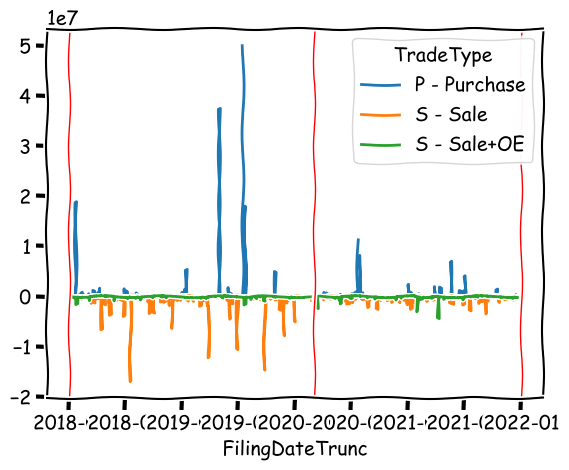

In [27]:
with plt.xkcd():
    pd.DataFrame(selected_trades.groupby(['TradeType', 'FilingDateTrunc'])['Qty'].mean()).reset_index().pivot(index='FilingDateTrunc', columns = 'TradeType', values = 'Qty').plot()
    interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

    for int_ in interval_borders:
        plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)
plt.show()

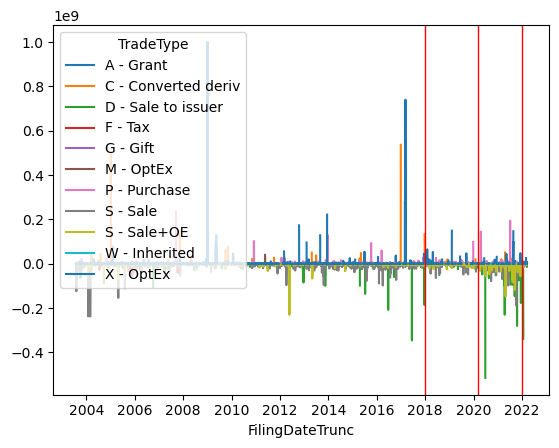

In [30]:
pd.DataFrame(all_insider_trades.groupby(['TradeType', 'FilingDateTrunc'])['Value'].mean()).reset_index().pivot(index='FilingDateTrunc', columns = 'TradeType', values = 'Value').plot()
interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)
plt.show()

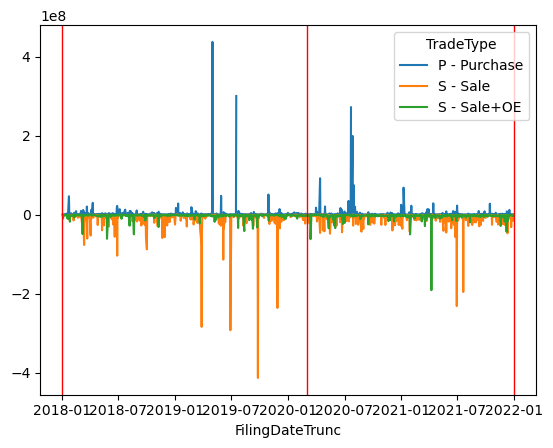

In [19]:
pd.DataFrame(selected_trades.groupby(['TradeType', 'FilingDateTrunc'])['Value'].mean()).reset_index().pivot(index='FilingDateTrunc', columns = 'TradeType', values = 'Value').plot()
interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)
plt.show()

In [13]:
print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)


get filing lags ...


100%|██████████| 1534/1534 [01:55<00:00, 13.26it/s]


Negative lag for 153 out of 1098006 trades.
Lag longer than 21 days for 27344 out of 1098006 trades.
Eligible trades: 1070509 out of 1098006 trades.


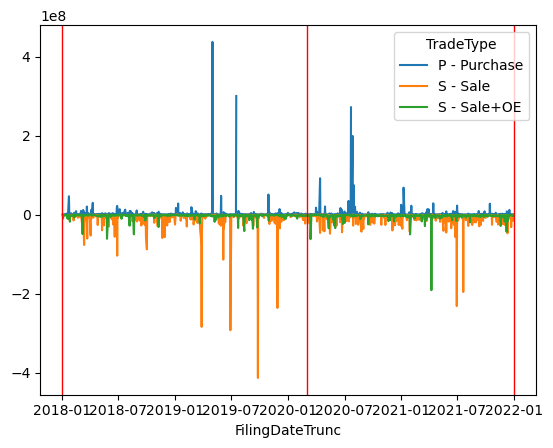

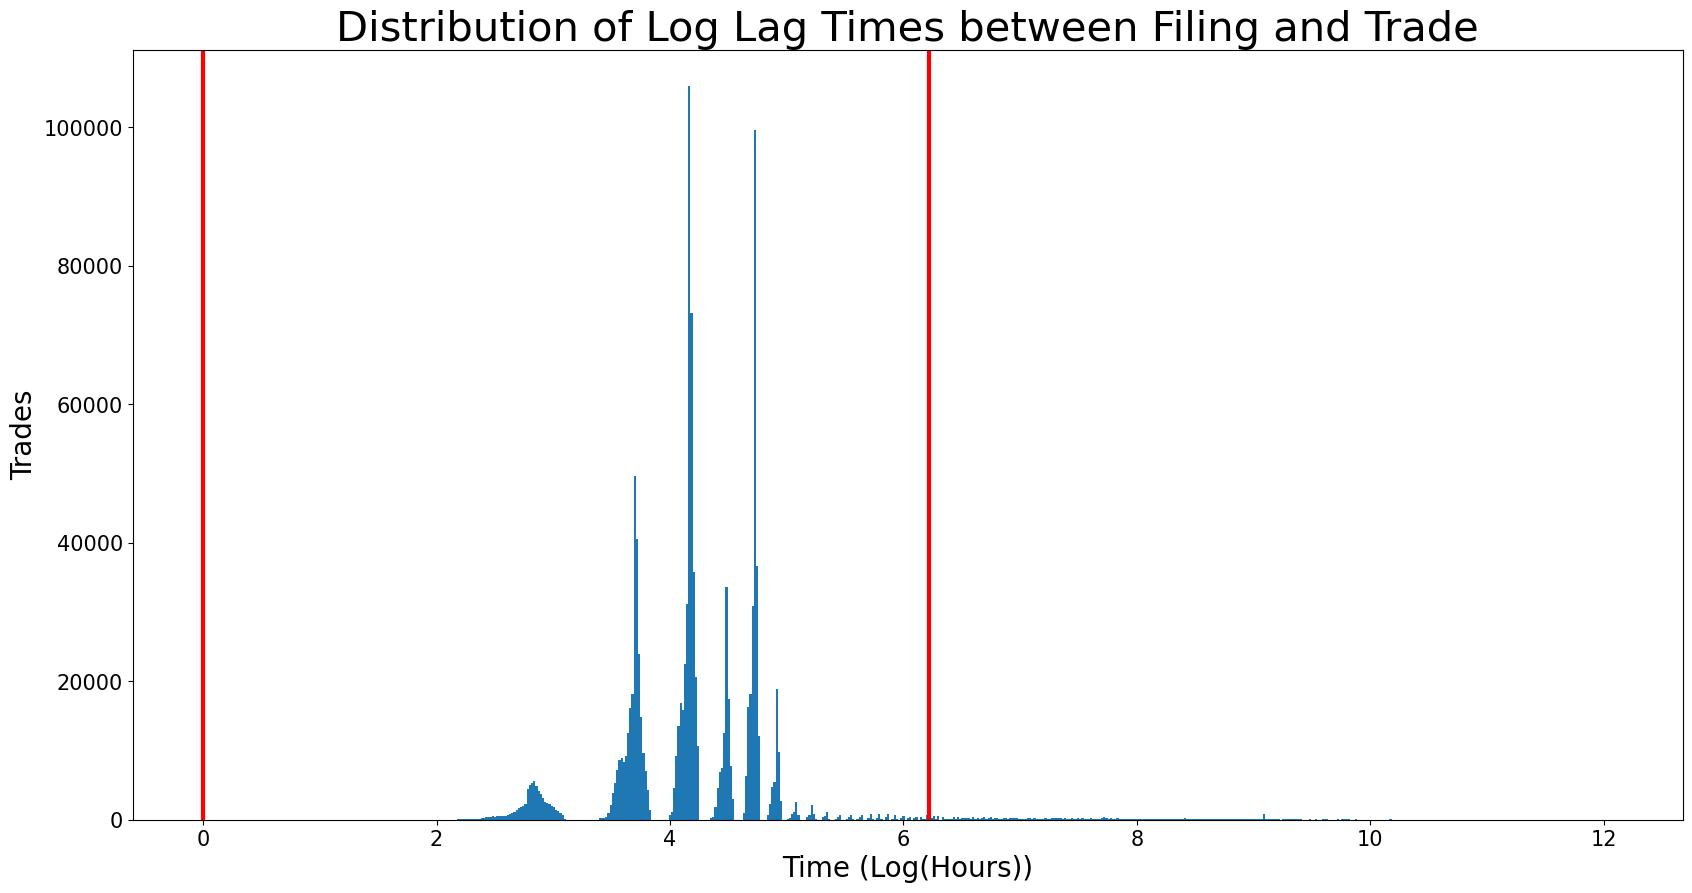

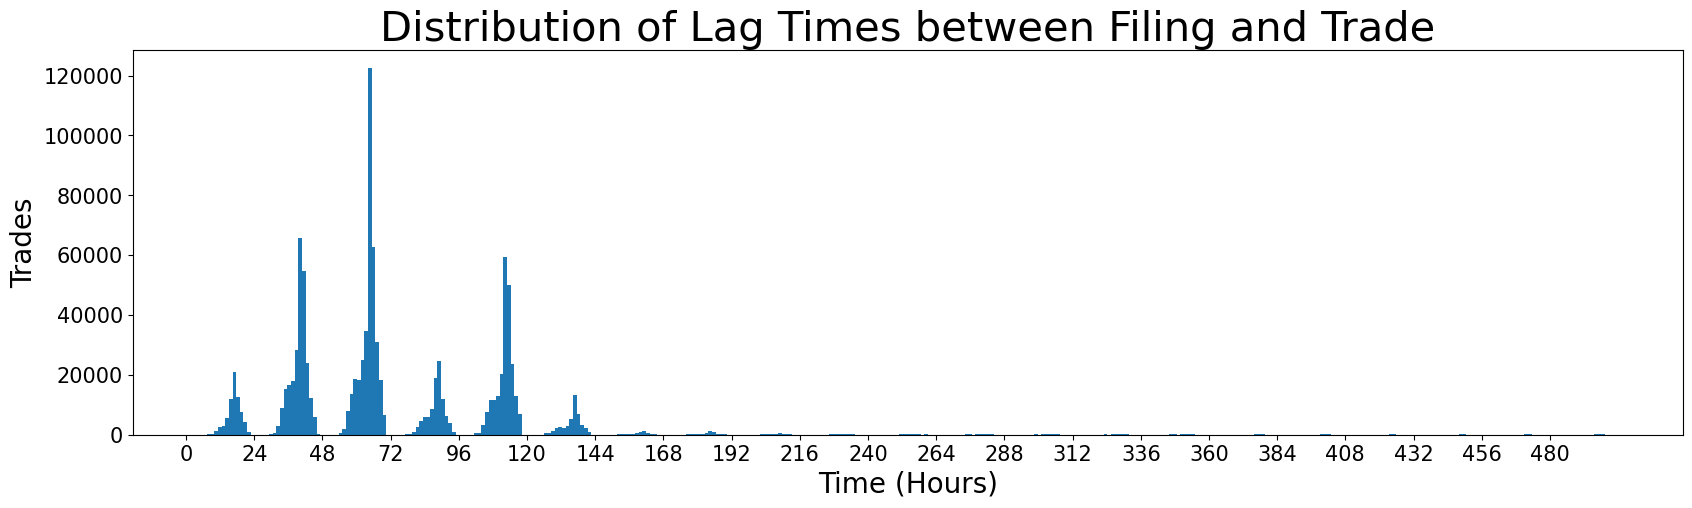

In [14]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 3)
plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 3)
plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.png", dpi=600, bbox_inches='tight')
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(fig_height, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

#plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.png", dpi=600, bbox_inches='tight')
plt.show()

Negative lag for 153 out of 1098006 trades.
Lag longer than 21 days for 27344 out of 1098006 trades.
Eligible trades: 1070509 out of 1098006 trades.


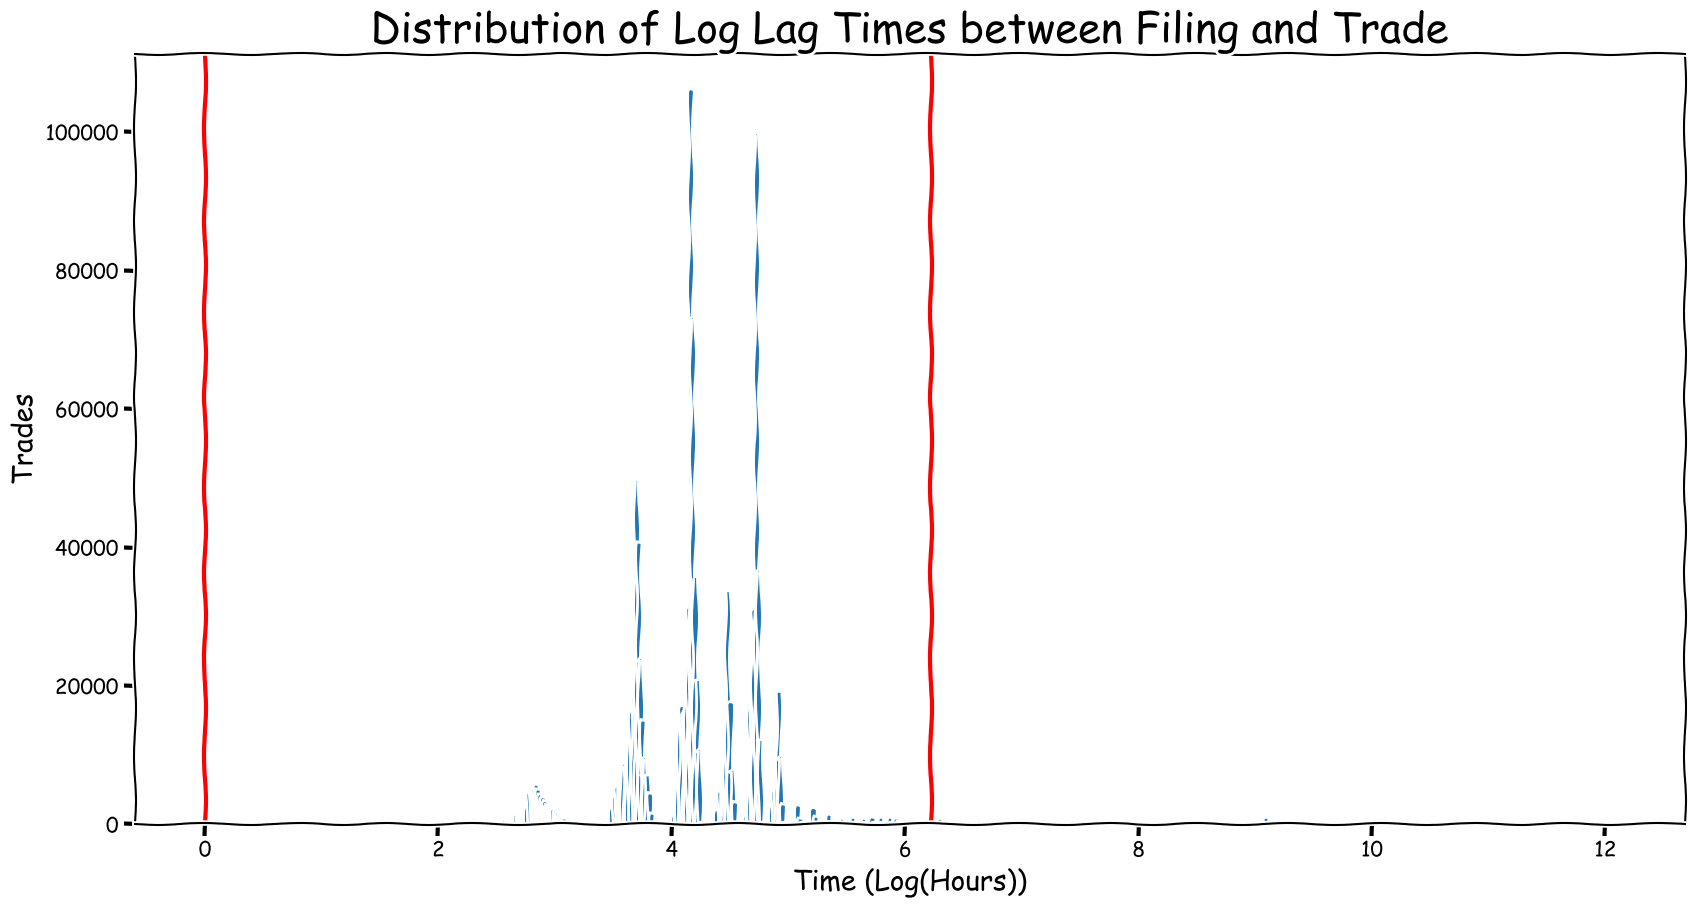

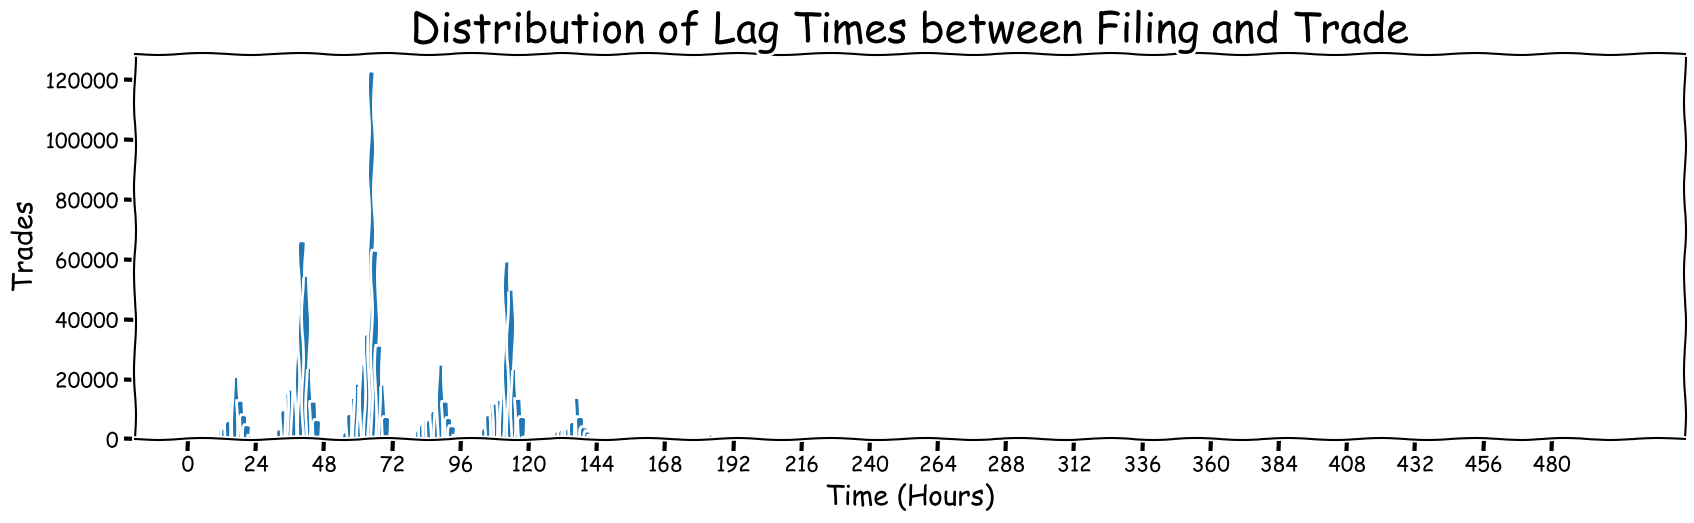

In [15]:
with plt.xkcd():
    filing_trade_lags = sum(lags, [])

    lag_in_hours = np.asarray(filing_trade_lags)
    negative_lag_mask = lag_in_hours < 0
    positive_lag = lag_in_hours[~negative_lag_mask]
    in_21_days = positive_lag < 21*24
    relevant_lag = positive_lag[in_21_days]
    print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
    print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
    print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

    fig = plt.figure(figsize=(fig_height, 10))
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(np.log(positive_lag), bins="auto")
    ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
    ax.set_ylabel('Trades', fontsize=label_size)
    ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)

    plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 3)
    plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 3)
    plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.png", dpi=600, bbox_inches='tight')
    plt.show()

    without_outliers = positive_lag[positive_lag < 24*21]

    fig = plt.figure(figsize=(fig_height, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(without_outliers, bins="auto")
    plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
    ax.set_xlabel('Time (Hours)', fontsize=label_size)
    ax.set_ylabel('Trades', fontsize=label_size)
    ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)

    #plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.png", dpi=600, bbox_inches='tight')
    plt.show()

In [ ]:
with plt.xkcd():
    plt.plot(np.sin(np.linspace(0, 10)))
    plt.title('Whoo Hoo!!!')

In [ ]:
x = np.linspace(0, 10)
y1 = x * np.sin(x)
y2 = x * np.cos(x)

with plt.xkcd():
    plt.fill(x, y1, 'red', alpha=0.4)
    plt.fill(x, y2, 'blue', alpha=0.4)
    plt.xlabel('x axis yo!')
    plt.ylabel("I don't even know")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import numpy as np


with plt.xkcd():
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    x = np.linspace(0, 10, 30)
    colors = ['r', 'g', 'b', 'y']
    y = np.random.random((len(colors), len(x)))
    y[:, 0] = y[:, -1] = 0

    edges = [list(zip(x, yi)) for yi in y]

    poly = PolyCollection(edges, facecolors=colors, alpha=0.6)
    ax.add_collection3d(poly, zs=range(4), zdir='y')

    ax.set_xlabel('X')
    ax.set_xlim3d(0, 10)
    ax.set_ylabel('Y')
    ax.set_ylim3d(-1, 4)
    ax.set_zlabel('Z')
    ax.set_zlim3d(0, 1)

In [ ]:
with plt.xkcd():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)

    years = np.linspace(1975, 2013)
    pct = 2 + 98. / (1 + np.exp(0.6 * (2008 - years)))
    ax.plot(years, pct)

    ax.set_xlim(1976, 2013)
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%i%%'))

    ax.text(1977, 67,
            ("Percentage of the US Population\n"
             "carrying cameras everywhere they go,\n"
             "every waking moment of their lives:"),
            size=16)

    ax.set_xlabel(("In the last few years, with very little fanfare,\n"
                   "We've conclusively settled the questions of\n"
                   "flying saucers, lake monsters, ghosts, and bigfoot."),
                  size=16)